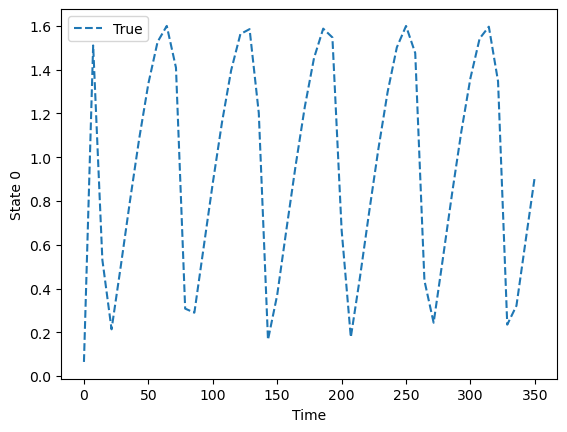

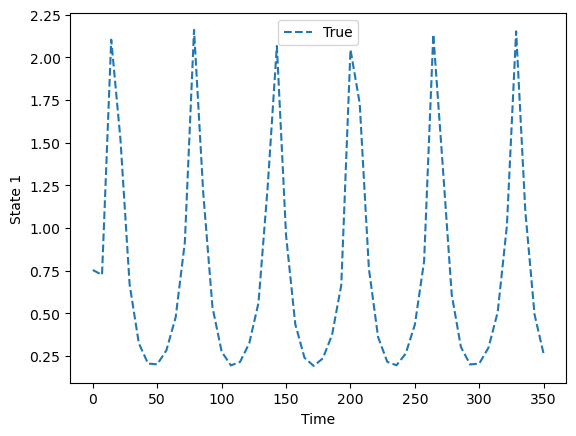

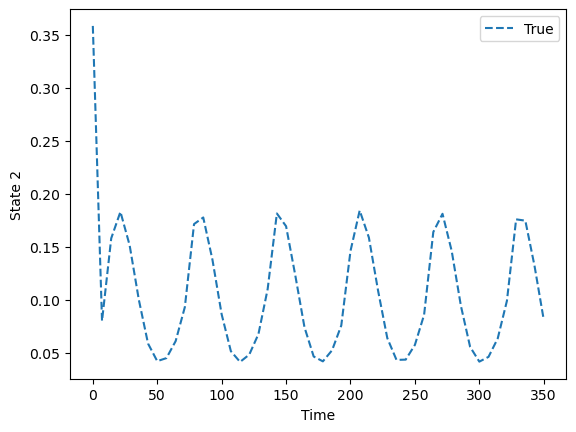

In [4]:
import numpy as np
import matplotlib.pyplot as plt

ntraj = 2148  # number of trajectories
nt = 50  # number of time steps
ny = 7  # number of states

tvec = np.linspace(0, 350, nt)
Y = np.loadtxt("kdata.txt").reshape(ntraj, nt, ny)
Ytrain = Y[:2048, :, :]  # 2048 training trajectories
Ytest = Y[2048:, :, :]  # 100 testing trajectoreis


def plot_traj(ytrue, ymodel=None, tvect=tvec):
    plt.figure()
    plt.plot(tvect, ytrue[:, 0], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 0], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 0")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(tvect, ytrue[:, 1], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 1], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 1")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(tvect, ytrue[:, 2], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 2], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 2")
    plt.legend()
    plt.show()


plot_traj(Ytest[0, :, :])

In [5]:
import torch
import torch.nn as nn


class KoopmanNN(nn.Module):
    def __init__(
        self,
        input_dim,
        num_autoencoder_layers,
        width_autoencoder_layers,
        latent_dim,
        activation=nn.LeakyReLU,
    ):
        super(KoopmanNN, self).__init__()
        encoder = []
        decoder = []
        for i in range(num_autoencoder_layers):
            if i == 0:
                encoder.append(nn.Linear(input_dim, width_autoencoder_layers))
            else:
                encoder.append(
                    nn.Linear(
                        width_autoencoder_layers, width_autoencoder_layers
                    )
                )
            encoder.append(activation())
        #     encoder.append(nn.Dropout(0.1))
        # encoder.pop()
        encoder.append(nn.Linear(width_autoencoder_layers, latent_dim))
        self.encoder = nn.Sequential(*encoder)

        for i in range(num_autoencoder_layers):
            if i == 0:
                decoder.append(nn.Linear(latent_dim, width_autoencoder_layers))
            else:
                decoder.append(
                    nn.Linear(
                        width_autoencoder_layers, width_autoencoder_layers
                    )
                )
            decoder.append(activation())
        #     decoder.append(nn.Dropout(0.1))
        # decoder.pop()
        decoder.append(nn.Linear(width_autoencoder_layers, input_dim))
        self.decoder = nn.Sequential(*decoder)

        self.K_matrix = nn.Linear(latent_dim, latent_dim, bias=False)
        self.K_matrix.weight.data = (
            torch.randn(latent_dim, latent_dim) / latent_dim
        )

    def forward(self, x):
        z = self.encoder(x)
        xrecon = self.decoder(z)
        kz = self.K_matrix(z)
        xhat = self.decoder(kz)
        return xrecon, z, kz, xhat


def loss(x, xrecon, zs, kzs, xpred, alphas=[1, 1, 1]):
    recon_term = torch.mean((x - xrecon) ** 2)
    pred_term = torch.mean((x - xpred) ** 2)
    koopman_term = torch.mean((kzs - zs) ** 2)
    return (
        alpha[0] * recon_term + alpha[1] * pred_term + alpha[2] * koopman_term,
        recon_term,
        pred_term,
        koopman_term,
    )


def generate_traj(Yi, model, nt):
    y0 = Yi[0, :]
    xrecons = []
    zs = []
    kzs = []
    xpreds = [y0]
    for i in range(nt):
        xrecon, z, kz, xpred = model(y0)
        y0 = xpred
        xrecons.append(xrecon)
        zs.append(z)
        kzs.append(kz)
        xpreds.append(xpred)
    zs.pop(0)
    kzs.pop()
    xpreds.pop()

    xrecons = torch.stack(xrecons)
    zs = torch.stack(zs)
    kzs = torch.stack(kzs)
    xpreds = torch.stack(xpreds)
    return xrecons, zs, kzs, xpreds


100%|██████████| 400/400 [08:39<00:00,  1.29it/s, Reconstruction Loss=0.165, Prediction Loss=0.164, Koopman Loss=7.08e-5, epoch_loss=1.97, test_loss=0.491]  

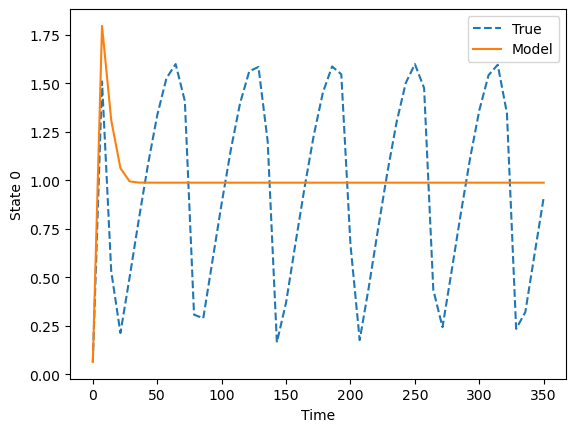

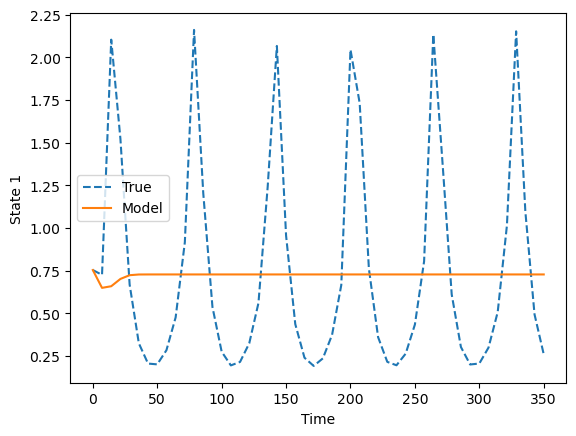

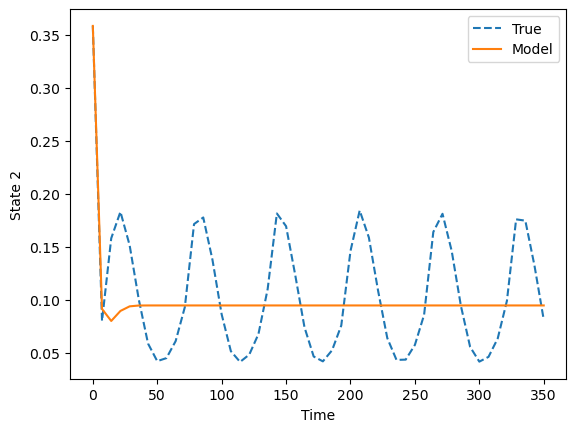

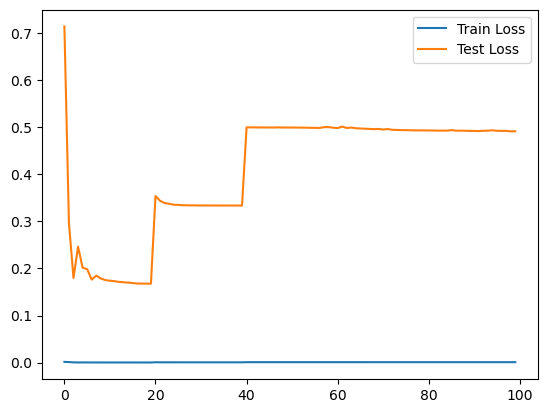

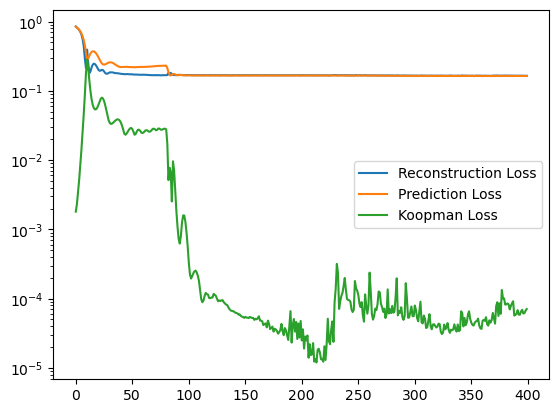

In [ ]:
# koopman loss: does each point after one follow linearity
#               ie. $phi(x_{m+1}) = K^m phi(x_1)$ for all m
# and prediction loss: is the state space prediction good
#     ie $x_{m+1} = phi^{-1}(K^m * phi(x_1))$ for all m
from tqdm import tqdm
import os

Epochs = 100
train_size = 2048
batch_size = 512

model = KoopmanNN(ny, 4, 256, latent_dim=32)
if os.path.exists("koopman_model.pt"):
    model = torch.load("koopman_model.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.8,
    patience=train_size,
    cooldown=train_size // 4,
    min_lr=1e-7,
)

tqdm = tqdm(total=Epochs * train_size // batch_size)
Ytrain = torch.tensor(Ytrain, dtype=torch.float32)
# Ytrain is shape Ntraj, Nt, Ny
Ytrain = Ytrain.permute(1, 0, 2)
# Ytrain is shape Nt, Ntraj, Ny
Ytest = torch.tensor(Ytest, dtype=torch.float32)
# Ytest = Ytest.permute(1, 0, 2)
Ytrain = Ytrain.cuda()
Ytest = Ytest.cuda()
model = model.cuda()

train_loss = []
test_losses = []
reconlosses = []
predlosses = []
koopmanlosses = []

alpha = [1, 0, 0]
try:
    for epoch in range(Epochs):
        Ytrain = Ytrain[:, torch.randperm(Ytrain.size()[1])]
        model.train()
        epoch_loss = 0
        if epoch == 20:
            alpha = [1, 1, 1]
        elif epoch == 40:
            alpha = [1, 2, 2]
        for i in range(0, train_size, batch_size):
            optimizer.zero_grad()
            Yi = Ytrain[:, i : i + batch_size, :]
            xrecons, zs, kzs, xpreds = generate_traj(Yi, model, nt)
            traj_loss, recon_term, pred_term, koopman_term = loss(
                Yi, xrecons, zs, kzs, xpreds, alpha
            )
            reconlosses.append(recon_term.item())
            predlosses.append(pred_term.item())
            koopmanlosses.append(koopman_term.item())
            epoch_loss += traj_loss
            traj_loss.backward()
            optimizer.step()
            tqdm.set_postfix(
                {
                    "Reconstruction Loss": recon_term.item(),
                    "Prediction Loss": pred_term.item(),
                    "Koopman Loss": koopman_term.item(),
                    "epoch_loss": epoch_loss.item(),
                    "test_loss": test_losses[-1] if len(test_losses) > 0 else 0,
                }
            )
            tqdm.update(1)
            scheduler.step(traj_loss)
        epoch_loss /= train_size
        train_loss.append(epoch_loss.item())
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i in range(100):
                Yi = Ytest[i, :, :]
                xrecons, zs, kzs, xpreds = generate_traj(Yi, model, nt)
                traj_loss, _, _, _ = loss(Yi, xrecons, zs, kzs, xpreds)
                test_loss += traj_loss
        test_loss /= 100
        test_losses.append(test_loss.item())
        # print(
        #     f"Epoch {epoch} train loss: {epoch_loss}, test loss: {test_loss}, lr: {optimizer.param_groups[0]['lr']}"
        # )
except KeyboardInterrupt:
    pass
except Exception as e:
    print(e)
    quit()

torch.save(model, "koopman_model.pt")

Ytest = Ytest.cpu()
model = model.cpu()

Y0 = Ytest[0, :, :]
xrecons, zs, kzs, xpreds = generate_traj(Y0, model, nt)
plot_traj(Y0.detach().numpy(), xpreds.detach().numpy())

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(reconlosses, label="Reconstruction Loss")
plt.plot(predlosses, label="Prediction Loss")
plt.plot(koopmanlosses, label="Koopman Loss")
plt.yscale("log")
plt.legend()